# Trabajo Práctico 1 : Reservas de Hotel

### Grupo 01 - Integrantes:
        Cabrera Rodríguez, Mateo 
        Gonzalez Alejo, Camila
        Bocanegra, Eduardo Martín

### Instalar dependencias

In [11]:
pip install -r ../requirements.txt

### Cargado de bibliotecas

In [77]:
#Datos
import numpy as np
import pandas as pd

#Plots
import matplotlib.pyplot as plt
import seaborn as sns

#Modelado
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

#preprocesamiento
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing


### Cargado de Dataset

In [37]:
ds = pd.read_csv('../datasets/hoteles_train2.csv')
ds_test = pd.read_csv('../datasets/hotels_test.csv')
ds.head(5)

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date,id,is_canceled
0,City Hotel,49,2016,September,37,5,1,2,1,0,...,No Deposit,9.0,0,Transient,115.5,0,1,2016-08-25,7aa4cc6b-b92c-4061-b21d-4f9e0cac4689,1
1,Resort Hotel,4,2015,October,44,31,0,1,2,0,...,No Deposit,NaN,0,Transient,42.0,1,0,2015-11-01,b1428f80-c56c-4ae4-91a9-6962edae08b1,0
2,City Hotel,25,2016,October,42,13,0,1,2,2,...,No Deposit,9.0,0,Transient,229.0,0,2,2016-10-14,2226c018-ea20-4c4e-8f71-ea66aee70d7c,0
3,City Hotel,26,2016,December,51,12,2,5,2,0,...,Non Refund,154.0,0,Transient,75.0,0,0,2016-11-29,314f56dc-2e4d-4298-9bdd-27bb008bffff,1
4,City Hotel,104,2017,March,12,19,2,5,2,0,...,No Deposit,20.0,0,Transient-Party,75.0,0,1,2017-03-26,28c75445-c603-413a-babf-ad377018b592,0


## Checkpoint 3

### K-Nearest Neighbors (KNN)

El algoritmo K-Nearest Neighbors, o simplemente KNN, funciona obteniendo un punto dado y evaluando sus "k" vecinos para encontrar similitudes. 

Se puede utilizar para clasificación o regresión.

La idea se basa en el hecho de que los puntos de datos similares estarán más cerca en el espacio que los puntos que son muy diferentes entre sí.  

#### Trabajo sobre nulos

In [58]:
# Trabajo sobre valores nulos
agents = ds['agent'].unique()
agents = np.delete(agents, 1)
ds['agent'].fillna(0, inplace=True)

agents = ds_test['agent'].unique()
agents = np.delete(agents, 1)
ds_test['agent'].fillna(0, inplace=True)

#### Transformacion de variables categoricas

In [59]:
# Transformacion de variables categoricas

import string

# encoding ordinal

ds = ds.replace({'meal': {'BB': 0, 'HB': 1, 'FB': 2, 'SC': 3, 'Undefined': 4},# ver que hacer con undefined
                 'arrival_date_month': {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7, 'August': 8, 'September': 9, 'October': 10,'November': 11, 'December': 12},
                 'reserved_room_type': {a : n for n, a in enumerate(string.ascii_uppercase)},
                 'assigned_room_type': {a : n for n, a in enumerate(string.ascii_uppercase)},
                 'deposit_type': {'No Deposit': 0, 'Refundable': 1, 'Non Refund': 2},
                 'agent': {agent : 1 for agent in agents}})

ds_test = ds_test.replace({'meal': {'BB': 0, 'HB': 1, 'FB': 2, 'SC': 3, 'Undefined': 4},# ver que hacer con undefined
                 'arrival_date_month': {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7, 'August': 8, 'September': 9, 'October': 10,'November': 11, 'December': 12},
                 'reserved_room_type': {a : n for n, a in enumerate(string.ascii_uppercase)},
                 'assigned_room_type': {a : n for n, a in enumerate(string.ascii_uppercase)},
                 'deposit_type': {'No Deposit': 0, 'Refundable': 1, 'Non Refund': 2},
                 'agent': {agent : 1 for agent in agents}})

# Si meal es Undefined o vacío, reemplazamos por SC (dice el paper)
# ds['meal'] = ds['meal'].apply(lambda x: 'SC' if x in ['Undefined', 'null', ''] else x)
# ds = pd.get_dummies(ds, columns=['assigned_room_type'], drop_first=True)
# ds = pd.get_dummies(ds, columns=['reserved_room_type'], drop_first=True)
# ds = pd.get_dummies(ds, columns=['meal'], drop_first=True)
# ds = pd.get_dummies(ds, columns=['deposit_type'], drop_first=True)
# ds = pd.get_dummies(ds, columns=['agent'], drop_first=True)

In [60]:
label_encoder = LabelEncoder()
ds['market_segment'] = label_encoder.fit_transform(ds['market_segment'])
ds['distribution_channel'] = label_encoder.fit_transform(ds['distribution_channel'])
ds['customer_type'] = label_encoder.fit_transform(ds['customer_type'])

ds_test['market_segment'] = label_encoder.fit_transform(ds_test['market_segment'])
ds_test['distribution_channel'] = label_encoder.fit_transform(ds_test['distribution_channel'])
ds_test['customer_type'] = label_encoder.fit_transform(ds_test['customer_type'])

#ds['arrival_date_month'] = label_encoder.fit_transform(ds['arrival_date_month'])

#### Separacion de datos

In [61]:
# Definicion de excluidos y target

excluidos = ['hotel', 'reservation_status_date', 'id']

target = 'is_canceled'
features = [col for col in ds.columns if col not in excluidos+[target]]

In [62]:
#Separar datos y etiquetas
x = ds[features].values
y = ds[target].values

#Separo conjunto de Train y de Test (80/20)
x_train, x_test, y_train, y_test = train_test_split(x, y , test_size=0.20, random_state=0, stratify=ds[target].values)

#### Creacion de un modelo KNN con sus parametros por defecto

In [63]:
#Creamos el modelo
KNN_Classifier = KNeighborsClassifier()

#vemos sus parámetros
KNN_Classifier.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [64]:
#Entrenamos el modelo
KNN_Classifier.fit(x_train, y_train)

#Predicción sobre test
y_pred = KNN_Classifier.predict(x_test)

In [65]:
#Cantidad de aciertos
print('correctas: ', np.sum(y_test == y_pred))
print('total: ', len(y_test))

correctas:  8987
total:  12343


In [68]:
accuracy_score(y_test,y_pred)

0.7281049987847363

#### Matriz de confusion ^

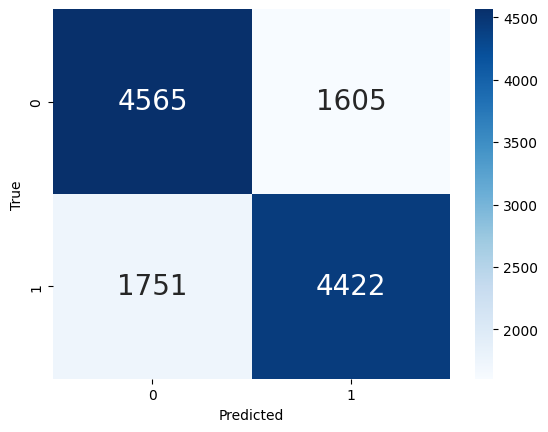

In [67]:
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues', annot=True, fmt='g', annot_kws={'size':20})
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#### Buscamos los mejores hiperparametros mediante k-fold Cross Validation

In [70]:
# Definir el rango de posibles valores para los hiperparámetros
params_grid = {'n_neighbors': [3, 5, 7, 9],
              'weights': ['uniform', 'distance'],
              'metric': ['euclidean', 'manhattan','chebyshev']}

# Crear una instancia de GridSearchCV con la grilla de hiperparámetros y la métrica de desempeño
grid_search = GridSearchCV(estimator=KNN_Classifier, param_grid=params_grid, scoring='accuracy', cv=5)

# Entrenar el modelo con GridSearchCV para encontrar los mejores hiperparámetros
grid_search.fit(x_train, y_train)

# Mostrar los mejores hiperparámetros y la métrica de desempeño del modelo
print('Mejores hiperparámetros:', grid_search.best_params_)
print('Mejor score:', grid_search.best_score_)


Mejores hiperparámetros: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}
Mejor score: 0.7629734656674094


In [90]:
# Definir el rango de posibles valores para los hiperparámetros
# params_grid = {'n_neighbors': range(1,50),
#               'weights': ['uniform', 'distance'],
#               'metric': ['euclidean', 'manhattan','chebyshev', 'canberra', 'minkowski', 'cosine', 'correlation']}

params_grid = { 'n_neighbors': [30], 
                'weights': ['distance'],
                'metric': ['canberra'],}

# 'braycurtis','canberra','chebyshev','correlation',
#         'cosine','dice','hamming','jaccard','kulsinski',
#         'mahalanobis','matching','minkowski','rogerstanimoto',
#         'russellrao','seuclidean','sokalmichener','sokalsneath',
#         'sqeuclidean','yule','wminkowski',

# Crear una instancia de GridSearchCV con la grilla de hiperparámetros y la métrica de desempeño
grid_search = GridSearchCV(estimator=KNN_Classifier, param_grid=params_grid, scoring='accuracy', cv=5)

# Entrenar el modelo con GridSearchCV para encontrar los mejores hiperparámetros
grid_search.fit(x_train, y_train)

# Mostrar los mejores hiperparámetros y la métrica de desempeño del modelo
print('Mejores hiperparámetros:', grid_search.best_params_)
print('Mejor score:', grid_search.best_score_)

Mejores hiperparámetros: {'metric': 'canberra', 'n_neighbors': 30, 'weights': 'distance'}
Mejor score: 0.8119303220579299


###### Mejores hiperparámetros: {'metric': 'canberra', 'n_neighbors': 30, 'weights': 'distance'}
###### Mejor score: 0.8119303220579299

#### Matriz de confusion ^

In [92]:
best_n_neighbors = 30
best_weights = 'distance'
best_metric = 'canberra'

best_knn = KNeighborsClassifier(n_neighbors=best_n_neighbors, weights=best_weights, metric=best_metric)

# Entrenar el modelo con los datos de entrenamiento
best_knn.fit(x_train, y_train)

# Realizar predicciones en datos de prueba
y_pred = best_knn.predict(x_test)
accuracy_score(y_test,y_pred)

0.8171433201004618

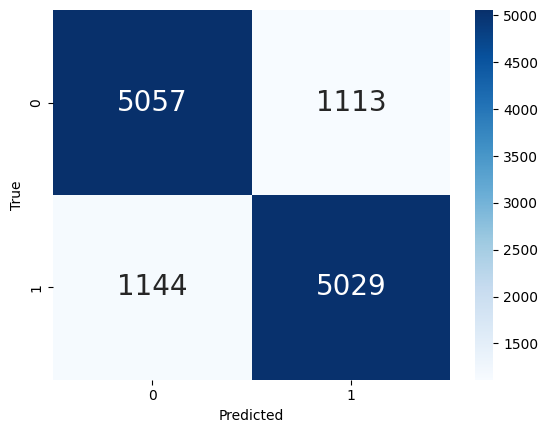

In [93]:
#Matriz de confusion
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues', annot=True, fmt='g', annot_kws={'size':20})
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Normalizacion de Datos + SVM (Probando distintos kernels)

#### Normalizacion de datos

In [ ]:
#Version escalada
min_max_scaler = preprocessing.MinMaxScaler()
x_train_minmax = min_max_scaler.fit_transform(x_train) 
x_test_minmax  = min_max_scaler.transform(x_test) 

#Version estandarizada
stand_scaler = preprocessing.StandardScaler()
x_train_norm = stand_scaler.fit_transform(x_train)
x_test_norm=stand_scaler.transform(x_test)

#### Construccion de modelo SVM

In [ ]:
svm = SVC()

#Lo entreno con los datos sin escalar
svm.fit(x_train, y_train)

y_pred=svm.predict(x_test)
classification_report(y_test,y_pred)

#### Matriz de confusion ^

In [ ]:
#Matriz de confusion
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues', annot=True, fmt='g', annot_kws={'size':20})
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()